<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/Experiment/Experiment_7_10_inner_residual_models_esrnn__mqesrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 8.2 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 585 kB 64.9 MB/s 
     |████████████████████████████████| 596 kB 59.8 MB/s 
     |████████████████████████████████| 419 kB 69.7 MB/s 
     |████████████████████████████████| 140 kB 76.2 MB/s 
     |████████████████████████████████| 1.1 MB 46.9 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 67.7 MB/s 
     |████████████████████████████████| 271 kB 8.5 MB/s 
     |████████████████████████████████| 2.4 MB 42.5 MB/s 
     |████████████████████████████████| 2.3 MB 45.8 MB/s 
     |████████████████████████████████| 138 kB 47.9 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 3

In [8]:
! pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Original

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
# export
from typing import List

from neuralforecast.models.esrnn.esrnn import ESRNN

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 n_x: int = 0,
                 n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'median_residual',
                 cell_type: str = 'LSTM',
                 state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False,
                 learning_rate: float = 1e-3,
                 lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0.,
                 noise_std: float = 1e-3,
                 testing_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 training_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 loss: str = 'MQ',
                 val_loss: str = 'MQ',
                 frequency: str = 'D'):
        """ Multi-Quantile Exponential Smoothing Recurrent Neural Network
    
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentiles: List[float]
            This values are only for diagnostic evaluation.
        training_percentiles: List[float]
            Percentiles to train and forecast.
        loss: str
            Loss used to train.
            Available: 'MQ', 'wMQ'.
        val_loss: str
            Loss used to validate.
            Available: 'MQ', 'wMQ'.
        frequency: str
            Time series frequency.
        
        Notes
        -----
        **References:**
        `Application
        <https://arxiv.org/abs/2112.05673`__
        """
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(n_series=n_series,
                                      n_s=n_s,
                                      n_x=n_x,
                                      sample_freq=sample_freq,
                                      input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss,
                                      frequency=frequency)

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

In [ ]:
n_ds = 100 
n_ts = 1_000

output_size = 10

uids = [f'uid_{i + 1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

Y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [ ]:
np.random.seed(10)
Y_df['y'] = Y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [ ]:
Y_df = Y_df.sort_values(['unique_id', 'ds'])

In [ ]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=3*output_size,
                                  is_test=False,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=False)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-12-03 2020-01-01
1           2019-09-24 2019-12-02
INFO:root:
Total data 			100000 time stamps 
Available percentage=100.0, 	100000 time stamps 
Insample  percentage=70.0, 	70000 time stamps 
Outsample percentage=30.0, 	30000 time stamps 



In [ ]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=32,
                                shuffle=False)

In [ ]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=7*2,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='GRU',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpjk5wqy3m
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpjk5wqy3m/_remote_module_non_sriptable.py


## DRNN

In [ ]:
# AUTOGENERATED! DO NOT EDIT! File to edit: nbs/models_components__drnn.ipynb (unless otherwise specified).

__all__ = ['LSTMCell', 'ResLSTMCell', 'ResLSTMLayer', 'AttentiveLSTMLayer', 'DRNN']

# Cell
import torch
import torch.nn as nn

# Cell
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)
        gates = (torch.matmul(inputs, self.weight_ih.t()) + self.bias_ih +
                         torch.matmul(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)

# Cell
class ResLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.register_buffer('input_size', torch.Tensor([input_size]))
        self.register_buffer('hidden_size', torch.Tensor([hidden_size]))
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)

        ifo_gates = (torch.matmul(inputs, self.weight_ii.t()) + self.bias_ii +
                                  torch.matmul(hx, self.weight_ih.t()) + self.bias_ih +
                                  torch.matmul(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)

        cellgate = torch.matmul(hx, self.weight_hh.t()) + self.bias_hh

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
            hy = outgate * (ry + inputs)
        else:
            hy = outgate * (ry + torch.matmul(inputs, self.weight_ir.t()))
        return hy, (hy, cy)

# Cell
class ResLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        outputs = []
        for i in range(len(inputs)):
                out, hidden = self.cell(inputs[i], hidden)
                outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

# Cell
class AttentiveLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super(AttentiveLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        attention_hsize = hidden_size
        self.attention_hsize = attention_hsize

        self.cell = LSTMCell(input_size, hidden_size)
        self.attn_layer = nn.Sequential(nn.Linear(2 * hidden_size + input_size, attention_hsize),
                                        nn.Tanh(),
                                        nn.Linear(attention_hsize, 1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = dropout

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        outputs = []

        for t in range(len(inputs)):
            # attention on windows
            hx, cx = (tensor.squeeze(0) for tensor in hidden)
            hx_rep = hx.repeat(len(inputs), 1, 1)
            cx_rep = cx.repeat(len(inputs), 1, 1)
            x = torch.cat((inputs, hx_rep, cx_rep), dim=-1)
            l = self.attn_layer(x)
            beta = self.softmax(l)
            context = torch.bmm(beta.permute(1, 2, 0),
                                inputs.permute(1, 0, 2)).squeeze(1)
            out, hidden = self.cell(context, hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

# Cell
class DRNN(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dilations, dropout=0, cell_type='GRU', batch_first=False):
        super(DRNN, self).__init__()

        self.dilations = dilations
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        elif self.cell_type == "ResLSTM":
            cell = ResLSTMLayer
        elif self.cell_type == "AttentiveLSTM":
            cell = AttentiveLSTMLayer
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hidden, dropout=dropout)
            else:
                c = cell(n_hidden, n_hidden, dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])

            outputs.append(inputs[-dilation:])

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, dilated_steps = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size,
                                                       hidden=hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)

        return outputs, hidden

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            hidden = torch.zeros(batch_size * rate, hidden_size,
                                 dtype=dilated_inputs.dtype,
                                 device=dilated_inputs.device)
            hidden = hidden.unsqueeze(0)

            if self.cell_type in ['LSTM', 'ResLSTM', 'AttentiveLSTM']:
                hidden = (hidden, hidden)

        dilated_outputs, hidden = cell(dilated_inputs, hidden) # compatibility hack

        return dilated_outputs, hidden

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]

        interleaved = torch.stack((blocks)).transpose(1, 0).contiguous()
        interleaved = interleaved.view(dilated_outputs.size(0) * rate,
                                       batchsize,
                                       dilated_outputs.size(2))
        return interleaved

    def _pad_inputs(self, inputs, n_steps, rate):
        iseven = (n_steps % rate) == 0

        if not iseven:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0),
                                 inputs.size(1),
                                 inputs.size(2),
                                 dtype=inputs.dtype,
                                 device=inputs.device)
            inputs = torch.cat((inputs, zeros_))
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

## ESRNN

In [ ]:

__all__ = ['ESRNN']

# Cell
import numpy as np
import torch as t
import torch.nn as nn


# Cell
#TODO: rnn con canales
#TODO: notacion de todo, windows_y_insample
class _ES(nn.Module):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ES, self).__init__()

        self.n_series = n_series
        self.input_size = input_size
        self.output_size = output_size
        self.output_size_m = output_size_m
        self.n_t = n_t
        self.n_s = n_s
        self.seasonality = seasonality
        assert len(self.seasonality) in [0, 1, 2]

        self.noise_std = noise_std

    def gaussian_noise(self, Y: t.Tensor, std: float=0.2):
        size = Y.size()
        noise = t.autograd.Variable(Y.data.new(size).normal_(0, std))
        return Y + noise

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        pass

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor, start: int, end: int):
        pass

    def predict(self, trend: t.Tensor, levels: t.Tensor, seasonalities: t.Tensor):
        pass

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # parse attributes
        input_size = self.input_size
        output_size = self.output_size
        n_t = self.n_t
        n_s = self.n_s
        context_size = input_size + (input_size+output_size)*n_t + n_s
        noise_std = self.noise_std
        seasonality = self.seasonality
        batch_size = len(idxs)

        n_series, n_time = Y.shape

        # Explicacion: windows_end es el idx delultimo inicio de windows. Como se necesitan windows completas con input
        # + output, se pierden (input_size+output_size-1) windows del len total de la serie.
        windows_end = n_time - input_size - output_size + 1
        #windows_range = range(0, windows_end, step_size)
        windows_range = range(0, windows_end)
        n_windows = len(windows_range)

        assert n_windows>0

        # Initialize windows, levels and seasonalities
        levels, seasonalities = self.compute_levels_seasons(Y=Y, idxs=idxs)
        windows_y_insample = t.zeros((n_windows, batch_size, context_size),
                                     device=Y.device)
        windows_y_outsample = t.zeros((n_windows, batch_size, output_size),
                                      device=Y.device)

        for i, window in enumerate(windows_range):
            # Windows yhat
            y_insample_start = window
            y_insample_end   = input_size + window

            # Y_hat deseasonalization and normalization
            window_y_insample = self.normalize(Y=Y[:, y_insample_start:y_insample_end],
                                               level=levels[:, [y_insample_end-1]],
                                               seasonalities=seasonalities,
                                               start=y_insample_start, end=y_insample_end) #TODO: improve this inputs

            if self.training:
                window_y_insample = self.gaussian_noise(window_y_insample, std=noise_std)

            if n_t > 0:
                window_x_t = X[:, :, y_insample_start:(y_insample_end+output_size)]
                window_x_t = window_x_t.reshape(batch_size, -1)
                window_y_insample = t.cat((window_y_insample, window_x_t), 1)

            # Concatenate S static variables matrix
            if n_s > 0:
                window_y_insample = t.cat((window_y_insample, S), 1)

            windows_y_insample[i, :, :] += window_y_insample

            # Windows_y_outsample
            y_outsample_start = y_insample_end
            y_outsample_end = y_outsample_start + output_size
            window_y_outsample = Y[:, y_outsample_start:y_outsample_end]
            # If training, normalize outsample for loss on normalized data
            if self.training:
                # Y deseasonalization and normalization
                window_y_outsample = self.normalize(Y=window_y_outsample,
                                                    level=levels[:, [y_outsample_start]],
                                                    seasonalities=seasonalities,
                                                    start=y_outsample_start, end=y_outsample_end) #TODO: improve this inputs
            windows_y_outsample[i, :, :] += window_y_outsample


        # Wrangles the sample_mask with same indexes as windows_y_outsample
        n_windows, n_batch, n_output = windows_y_outsample.shape
        sample_mask = sample_mask.unfold(dimension=-1, size=self.output_size, step=1)
        sample_mask = sample_mask[:, -n_windows:, :]
        sample_mask = sample_mask.permute(1,0,2)

        return windows_y_insample, windows_y_outsample, levels, seasonalities, sample_mask

# Cell
class _ESI(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ESI, self).__init__(n_series, input_size, output_size,
                                   output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        self.W = t.nn.Parameter(t.randn(1))
        self.W.requires_grad = False

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        levels = t.ones(Y.shape, device=Y.device)
        seasonalities = None
        return levels, None

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor,
                  start: int, end: int):
        return Y

    def predict(self,
                trends: t.Tensor,
                levels: t.Tensor,
                seasonalities: t.Tensor):
        return trends

# Cell
class _MedianResidual(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_MedianResidual, self).__init__(n_series, input_size, output_size, output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        self.W = t.nn.Parameter(t.randn(1))
        self.W.requires_grad = False

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        """
        Computes levels and seasons
        """
        y_transformed, _ = Y.median(1)
        y_transformed = y_transformed.reshape(-1, 1)
        levels = y_transformed.repeat(1, Y.shape[1])
        seasonalities = None

        return levels, None

    def normalize(self, Y: t.Tensor, level: t.Tensor,
                  seasonalities: t.Tensor,
                  start: int, end: int):

        return Y - level

    def predict(self,
                trends: t.Tensor,
                levels: t.Tensor,
                seasonalities: t.Tensor):
        levels = levels[:, (self.input_size-1):-self.output_size]
        levels = levels.unsqueeze(2)

        return trends + levels

# Cell
class _ESM(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ESM, self).__init__(n_series, input_size, output_size,
                                   output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        # Level and Seasonality Smoothing parameters
        # 1 level, S seasonalities, S init_seas
        embeds_size = 1 + len(self.seasonality) + sum(self.seasonality)
        init_embeds = t.ones((self.n_series, embeds_size)) * 0.5
        self.embeds = nn.Embedding(self.n_series, embeds_size)
        self.embeds.weight.data.copy_(init_embeds)
        self.seasonality = t.LongTensor(self.seasonality)

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        """
        Computes levels and seasons
        """
        # Lookup parameters per serie
        #seasonality = self.seasonality
        embeds = self.embeds(idxs)
        lev_sms = t.sigmoid(embeds[:, 0])

        # Initialize seasonalities
        seas_prod = t.ones(len(Y[:,0]), device=Y.device)
        seasonalities1 = []
        seasonalities2 = []
        seas_sms1 = t.ones(1, device=Y.device)
        seas_sms2 = t.ones(1, device=Y.device)

        if len(self.seasonality)>0:
            seas_sms1 = t.sigmoid(embeds[:, 1])
            init_seas1 = t.exp(embeds[:, 2:(2+self.seasonality[0])]).unbind(1)
            assert len(init_seas1) == self.seasonality[0]

            for i in range(len(init_seas1)):
                seasonalities1 += [init_seas1[i]]
            seasonalities1 += [init_seas1[0]]
            seas_prod = seas_prod * init_seas1[0]

        if len(self.seasonality)==2:
            seas_sms2 = t.sigmoid(embeds[:, 2+self.seasonality[0]])
            init_seas2 = t.exp(embeds[:, 3+self.seasonality[0]:]).unbind(1)
            assert len(init_seas2) == self.seasonality[1]

            for i in range(len(init_seas2)):
                seasonalities2 += [init_seas2[i]]
            seasonalities2 += [init_seas2[0]]
            seas_prod = seas_prod * init_seas2[0]

        # Initialize levels
        levels = []
        levels += [Y[:,0]/seas_prod]

        # Recursive seasonalities and levels
        ys = Y.unbind(1)
        n_time = len(ys)
        for t_idx in range(1, n_time):
            seas_prod_t = t.ones(len(Y[:,t_idx]), device=Y.device)
            if len(self.seasonality)>0:
                seas_prod_t = seas_prod_t * seasonalities1[t_idx]
            if len(self.seasonality)==2:
                seas_prod_t = seas_prod_t * seasonalities2[t_idx]

            newlev = lev_sms * (ys[t_idx] / seas_prod_t) + (1-lev_sms) * levels[t_idx-1]
            levels += [newlev]

            if len(self.seasonality)==1:
                newseason1 = seas_sms1 * (ys[t_idx] / newlev) + (1-seas_sms1) * seasonalities1[t_idx]
                seasonalities1 += [newseason1]

            if len(self.seasonality)==2:
                newseason1 = seas_sms1 * (ys[t_idx] / (newlev * seasonalities2[t_idx])) + \
                                         (1-seas_sms1) * seasonalities1[t_idx]
                seasonalities1 += [newseason1]
                newseason2 = seas_sms2 * (ys[t_idx] / (newlev * seasonalities1[t_idx])) + \
                                         (1-seas_sms2) * seasonalities2[t_idx]
                seasonalities2 += [newseason2]

        levels = t.stack(levels).transpose(1,0)

        seasonalities = []

        if len(self.seasonality)>0:
            seasonalities += [t.stack(seasonalities1).transpose(1,0)]

        if len(self.seasonality)==2:
            seasonalities += [t.stack(seasonalities2).transpose(1,0)]

        return levels, seasonalities

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor,
                  start: int, end: int):
        # Deseasonalization and normalization
        y_n = Y / level
        for s in range(len(self.seasonality)):
            y_n /= seasonalities[s][:, start:end]
        y_n = t.log(y_n)
        return y_n

    def predict(self, trends: t.Tensor, levels: t.Tensor, seasonalities: t.Tensor):

        # First trend uses last value of first y_insample of length self.input_size.
        # Last self.output_size levels are not used (leakeage!!!)
        levels = levels[:, (self.input_size-1):-self.output_size]
        levels = levels.unsqueeze(2)

        # Seasonalities are unfolded, because each element of trends must be multiplied
        # by the corresponding seasonality.
        for i in range(len(seasonalities)):
            seasonalities[i] = seasonalities[i][:, self.seasonality[i]:]
            seasonalities[i] = seasonalities[i].unfold(dimension=-1,
                                                       size=self.input_size + self.output_size,
                                                       step=1)
            seasonalities[i] = seasonalities[i][:,:,:self.input_size] #avoid leakage

            # Fill seasonalities with NaiveSeasonal, to avoid leakage.
            if self.output_size > seasonalities[i].shape[2]:
                repetitions = int(np.ceil(self.output_size / seasonalities[i].shape[2]))
                seasonalities[i] = seasonalities[i].repeat((1, 1, repetitions))
            seasonalities[i] = seasonalities[i][:, :, :self.output_size]

        # Denormalize
        trends = t.exp(trends)
        # Deseasonalization and normalization (inverse)
        y_hat = trends * levels
        for s in range(len(self.seasonality)):
            seas = seasonalities[s]
            y_hat *= t.vstack([seas.T for _ in range(self.output_size_m)]).T

        return y_hat

# Cell
class _RNN(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, cell_type: str, dilations: list, state_hsize: int, add_nl_layer: bool):
        super(_RNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_size_m = output_size_m
        self.n_t = n_t
        self.n_s = n_s

        self.cell_type = cell_type
        self.dilations = dilations
        self.state_hsize = state_hsize
        self.add_nl_layer = add_nl_layer
        self.layers = len(dilations)

        layers = []
        for grp_num in range(len(self.dilations)):
            if grp_num == 0:
                input_size = self.input_size + (self.input_size + self.output_size)*self.n_t + self.n_s
            else:
                input_size = self.state_hsize
            layer = DRNN(input_size,
                         self.state_hsize,
                         n_layers=len(self.dilations[grp_num]),
                         dilations=self.dilations[grp_num],
                         cell_type=self.cell_type)
            layers.append(layer)

        self.rnn_stack = nn.Sequential(*layers)

        if self.add_nl_layer:
            self.MLPW  = nn.Linear(self.state_hsize, self.state_hsize)

        self.adapterW  = nn.Linear(self.state_hsize, self.output_size * self.output_size_m)

    def forward(self, input_data: t.Tensor):
        for layer_num in range(len(self.rnn_stack)):
            residual = input_data
            output, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                output += residual
            input_data = output

        if self.add_nl_layer:
            input_data = self.MLPW(input_data)
            input_data = t.tanh(input_data)

        input_data = self.adapterW(input_data)

        return input_data

# Cell
class _ESRNN(nn.Module):
    def __init__(self, n_series, input_size, output_size,
                 output_size_m, n_t, n_s,
                 es_component, seasonality, noise_std, cell_type,
                 dilations, state_hsize, add_nl_layer):
        super(_ESRNN, self).__init__()
        allowed_componets = ['multiplicative', 'identity', 'median_residual']
        assert es_component in allowed_componets, f'es_component {es_component} not valid.'
        self.es_component = es_component

        if es_component == 'multiplicative':
            self.es = _ESM(n_series=n_series, input_size=input_size, output_size=output_size,
                           output_size_m=output_size_m, n_t=n_t, n_s=n_s,
                           seasonality=seasonality, noise_std=noise_std)
        elif es_component == 'identity':
            self.es = _ESI(n_series=n_series, input_size=input_size, output_size=output_size,
                           output_size_m=output_size_m, n_t=n_t, n_s=n_s,
                           seasonality=seasonality, noise_std=noise_std)
        elif es_component == 'median_residual':
            self.es = _MedianResidual(n_series=n_series, input_size=input_size, output_size=output_size,
                                      output_size_m=output_size_m, n_t=n_t, n_s=n_s,
                                      seasonality=seasonality, noise_std=noise_std)

        self.rnn = _RNN(input_size=input_size, output_size=output_size,
                        output_size_m=output_size_m,
                        n_t=n_t, n_s=n_s,
                        cell_type=cell_type, dilations=dilations,
                        state_hsize=state_hsize,
                        add_nl_layer=add_nl_layer)

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # Multiplicative model protection
        if self.es_component == 'multiplicative' and t.min(Y) == 0:
            raise Exception(
                'Check your Y data, multiplicative model only deals with Y>0. \n'
                f'Series: {idxs} \n'
                f'Min Y: {t.min(Y)}'
            )

        # ES Forward
        y_in, y_out, levels, seasonalities, sample_mask = self.es(S=S,Y=Y,X=X,idxs=idxs,
                                                                  sample_mask=sample_mask)

        # RNN Forward
        y_hat = self.rnn(y_in)

        if self.rnn.output_size_m > 1:
            n_w, n_ts, _ = y_in.shape
            y_hat = y_hat.view(n_w, n_ts, -1, self.rnn.output_size_m)

        return y_out, y_hat, levels, sample_mask

    def predict(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # ES Forward
        y_in, y_out, levels, seasonalities, sample_mask = self.es(S=S,Y=Y,X=X,idxs=idxs,
                                                                  sample_mask=sample_mask)
        # RNN Forward
        trends = self.rnn(y_in)

        # (n_windows, n_batch, n_input) -> (n_batch, n_windows, n_input)
        y_out = y_out.permute(1,0,2)
        trends = trends.permute(1,0,2)
        sample_mask = sample_mask.permute(1,0,2)

        y_hat = self.es.predict(trends, levels, seasonalities)

        if self.rnn.output_size_m > 1:
            n_ts, n_w, _ = y_out.shape
            y_hat = y_hat.view(n_ts, n_w, -1, self.rnn.output_size_m)

        return y_out, y_hat, sample_mask


In [ ]:
# Cell
from typing import Union, List

import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
from fastcore.foundation import patch
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.losses.utils import LossFunction

In [ ]:
# Cell
class ESRNN(pl.LightningModule):
    def __init__(self, n_series: int,
                 input_size: int, output_size: int,
                 n_x: int = 0, n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'multiplicative',
                 cell_type: str = 'LSTM', state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False, seasonality: List[int] = [],
                 learning_rate: float = 1e-3, lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9, per_series_lr_multip: float = 1.,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0., noise_std: float = 1e-3,
                 level_variability_penalty: float = 20.,
                 testing_percentile: Union[int, List] = 50,
                 training_percentile: Union[int, List] = 50,
                 loss: str = 'SMYL', val_loss: str = 'MAE',
                 frequency: str = 'D'):
        super(ESRNN, self).__init__()
        """ Exponential Smoothing Recurrent Neural Network
        Pytorch Implementation of the M4 time series forecasting competition winner.
        Proposed by Smyl. The model uses a hybrid approach of Machine Learning and
        statistical methods by combining recurrent neural networks to model a common
        trend with shared parameters across series, and multiplicative Holt-Winter
        exponential smoothing.
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        seasonality: int list
            list of seasonalities of the time series
            Hourly [24, 168], Daily [7], Weekly [52], Monthly [12],
            Quarterly [4], Yearly [].
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentile: int
            This value is only for diagnostic evaluation.
            In case of percentile predictions this parameter controls
            for the value predicted, when forecasting point value,
            the forecast is the median, so percentile=50.
        training_percentile: float
            To reduce the model's tendency to over estimate, the
            training_percentile can be set to fit a smaller value
            through the Pinball Loss.
        loss: str
            Loss used to train.
        val_loss: str
            Loss used to validate.
        frequency: str
            Time series frequency.
        Notes
        -----
        **References:**
        `M4 Competition Conclusions
        <https://rpubs.com/fotpetr/m4competition>`__
        `Original Dynet Implementation of ESRNN
        <https://github.com/M4Competition/M4-methods/tree/master/118%20-%20slaweks17>`__
        """

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_series = n_series
        self.n_x = n_x
        self.n_s = n_s
        self.sample_freq = sample_freq
        self.input_size = input_size
        self.output_size = output_size
        self.es_component = es_component
        self.cell_type = cell_type
        self.state_hsize = state_hsize
        self.dilations = dilations
        self.add_nl_layer = add_nl_layer
        self.seasonality = seasonality

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_scheduler_step_size = lr_scheduler_step_size
        self.lr_decay = lr_decay
        self.per_series_lr_multip = per_series_lr_multip
        self.gradient_eps = gradient_eps
        self.gradient_clipping_threshold = gradient_clipping_threshold
        self.rnn_weight_decay = rnn_weight_decay
        self.noise_std = noise_std
        self.level_variability_penalty = level_variability_penalty
        self.testing_percentile = testing_percentile
        self.training_percentile = training_percentile
        self.loss = loss
        self.val_loss = val_loss
        self.loss_fn = LossFunction(loss,
                                    percentile=self.training_percentile,
                                    level_variability_penalty=self.level_variability_penalty)
        self.val_loss_fn = LossFunction(val_loss,
                                        percentile=self.testing_percentile,
                                        level_variability_penalty=self.level_variability_penalty)

        self.frequency = frequency
        # MQESRNN
        self.mq = isinstance(self.training_percentile, list)
        self.output_size_m = len(self.training_percentile) if self.mq else 1

        #Defining model
        self.model = _ESRNN(n_series=self.n_series,
                            input_size=self.input_size,
                            output_size=self.output_size,
                            output_size_m=self.output_size_m,
                            n_t=self.n_x, n_s=self.n_s,
                            es_component=self.es_component,
                            seasonality=self.seasonality,
                            noise_std=self.noise_std,
                            cell_type=self.cell_type,
                            dilations=self.dilations,
                            state_hsize=self.state_hsize,
                            add_nl_layer=self.add_nl_layer)

        self.automatic_optimization = False

    def parse_batch(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        #idxs = batch['ts_idxs']
        idxs = batch['idxs']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        av_condition = t.nonzero(t.min(available_mask, axis=0).values)
        min_time_stamp = int(av_condition.min())
        sample_condition = t.nonzero(t.min(sample_mask, axis=0).values)

        if sample_condition.nelement() == 0:
            max_time_stamp = int(av_condition.max())
        else:
            max_time_stamp = int(sample_condition.max())
        available_ts = max_time_stamp - min_time_stamp + 1 # +1, inclusive counting
        if available_ts < self.input_size + self.output_size:
            raise Exception(
                'Time series too short for given input and output size. \n'
                f'Available timestamps: {available_ts}'
            )

        Y = Y[:, min_time_stamp:max_time_stamp + 1] #+1 because is not inclusive
        X = X[:, :, min_time_stamp:max_time_stamp + 1]
        sample_mask = sample_mask[:, min_time_stamp:max_time_stamp + 1]
        available_mask = available_mask[:, min_time_stamp:max_time_stamp + 1]

        return S, Y, X, idxs, sample_mask, available_mask

    def training_step(self, batch, batch_idx):
        es_opt, rnn_opt = self.optimizers()

        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        target, forecast, levels, sample_mask = self.model(S=S, Y=Y, X=X, idxs=idxs,
                                                           sample_mask=sample_mask)
        loss = self.loss_fn(y=target,
                            y_hat=forecast,
                            y_insample=Y,
                            levels=levels,
                            mask=sample_mask)

        es_opt.zero_grad()
        rnn_opt.zero_grad()
        self.manual_backward(loss)
        clip_grad_norm_(parameters=self.model.rnn.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        clip_grad_norm_(parameters=self.model.es.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        es_opt.step()
        rnn_opt.step()

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        for lr_scheduler in self.lr_schedulers():
            lr_scheduler.step()

    def validation_step(self, batch, idx):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        y_true, y_hat, sample_mask = self.model.predict(S=S, Y=Y, X=X, idxs=idxs,
                                                        sample_mask=sample_mask)

        y_true = y_true[:, ::self.sample_freq]
        y_hat = y_hat[:, ::self.sample_freq]
        sample_mask = sample_mask[:, ::self.sample_freq]

        loss = self.val_loss_fn(y=y_true,
                                y_hat=y_hat,
                                y_insample=Y)
        self.log('val_loss', loss, prog_bar=True)

        return loss

    def forward(self, batch):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        y_true, y_hat, sample_mask = self.model.predict(S=S, Y=Y, X=X, idxs=idxs,
                                                        sample_mask=sample_mask)

        y_true = y_true[:, ::self.sample_freq]
        y_hat = y_hat[:, ::self.sample_freq]
        sample_mask = sample_mask[:, ::self.sample_freq]

        return y_true, y_hat, sample_mask

    def configure_optimizers(self):
        es_optimizer = Adam(params=self.model.es.parameters(),
                            lr=self.learning_rate * self.per_series_lr_multip,
                            eps=self.gradient_eps)
        rnn_optimizer = Adam(params=self.model.rnn.parameters(),
                             lr=self.learning_rate,
                             eps=self.gradient_eps,
                             weight_decay=self.rnn_weight_decay)

        lr_es = StepLR(optimizer=es_optimizer,
                       step_size=self.lr_scheduler_step_size,
                       gamma=self.lr_decay)
        lr_rnn = StepLR(optimizer=rnn_optimizer,
                        step_size=self.lr_scheduler_step_size,
                        gamma=self.lr_decay)

        return [es_optimizer, rnn_optimizer], [lr_es, lr_rnn]

# Cell
@patch
def forecast(self: ESRNN, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None,
             batch_size: int =1, trainer: pl.Trainer =None) -> pd.DataFrame:
    """
    Method for forecasting self.output_size periods after last timestamp of Y_df.
    Parameters
    ----------
    Y_df: pd.DataFrame
        Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
    X_df: pd.DataFrame
        Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
        Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
    S_df: pd.DataFrame
        Dataframe with static data, needs 'unique_id' column.
    bath_size: int
        Batch size for forecasting.
    trainer: pl.Trainer
        Trainer object for model training and evaluation.
    Returns
    ----------
    forecast_df: pd.DataFrame
        Dataframe with forecasts.
    """

    # Add forecast dates to Y_df
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    if X_df is not None:
        X_df['ds'] = pd.to_datetime(X_df['ds'])
    forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.output_size+1, freq=self.frequency)[1:]
    index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
    forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()

    Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)

    # Dataset, loader and trainer
    dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df,
                                S_df=S_df,
                                ds_in_test=self.output_size,
                                is_test=True,
                                input_size=self.input_size,
                                output_size=self.output_size,
                                verbose=True)

    loader = TimeSeriesLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=False)

    if trainer is None:
        gpus = -1 if t.cuda.is_available() else 0
        trainer = pl.Trainer(progress_bar_refresh_rate=1,
                             gpus=gpus,
                             logger=False)

    # Forecast
    outputs = trainer.predict(self, loader)

    # Process forecast and include in forecast_df
    _, forecast, _ = zip(*outputs)
    forecast = t.cat([forecast_[:, -1] for forecast_ in forecast]).cpu().numpy()
    if self.mq:
        for iq, q in enumerate(self.training_percentile):
            forecast_df[f'y_p{q}'] = forecast[:, :, iq].flatten()
        forecast_df = forecast_df.drop(columns='y')
    else:
        forecast_df['y'] = forecast.flatten()

    return forecast_df

## MQESRNN

In [ ]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 n_x: int = 0,
                 n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'median_residual',
                 cell_type: str = 'LSTM',
                 state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False,
                 learning_rate: float = 1e-3,
                 lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0.,
                 noise_std: float = 1e-3,
                 testing_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 training_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 loss: str = 'MQ',
                 val_loss: str = 'MQ',
                 frequency: str = 'D'):
        """ Multi-Quantile Exponential Smoothing Recurrent Neural Network
    
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentiles: List[float]
            This values are only for diagnostic evaluation.
        training_percentiles: List[float]
            Percentiles to train and forecast.
        loss: str
            Loss used to train.
            Available: 'MQ', 'wMQ'.
        val_loss: str
            Loss used to validate.
            Available: 'MQ', 'wMQ'.
        frequency: str
            Time series frequency.
        
        Notes
        -----
        **References:**
        `Application
        <https://arxiv.org/abs/2112.05673`__
        """
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(n_series=n_series,
                                      n_s=n_s,
                                      n_x=n_x,
                                      sample_freq=sample_freq,
                                      input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss,
                                      frequency=frequency)

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

In [ ]:
n_ds = 100 
n_ts = 1_000

output_size = 10

uids = [f'uid_{i + 1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

Y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [ ]:
np.random.seed(10)
Y_df['y'] = Y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [ ]:

Y_df = Y_df.sort_values(['unique_id', 'ds'])

In [ ]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=3*output_size,
                                  is_test=False,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=False)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-12-03 2020-01-01
1           2019-09-24 2019-12-02
INFO:root:
Total data 			100000 time stamps 
Available percentage=100.0, 	100000 time stamps 
Insample  percentage=70.0, 	70000 time stamps 
Outsample percentage=30.0, 	30000 time stamps 



In [ ]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=32,
                                shuffle=False)

In [ ]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=7*2,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='ResLSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

In [ ]:
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=5, deterministic=True)
trainer.fit(model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=5)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,

  | Name  | Type   | Params
------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Run in the first

In [ ]:
outputs = trainer.predict(model, valid_loader)

Predicting: 32it [00:00, ?it/s]

In [ ]:
y_true, y_hat, mask = zip(*outputs)
y_true = t.cat(y_true).numpy()
y_hat = t.cat(y_hat).numpy()
mask = t.cat(mask).numpy()

In [ ]:

y_true = y_true[-1000:, -1]
y_hat = y_hat[-1000:, -1]

calibration p30:  0.3824
calibration p50:  0.5003
calibration p70:  0.6286
calibration p90:  0.7588


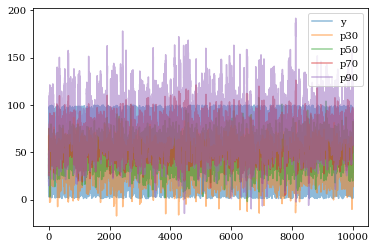

In [ ]:
plt.plot(y_true.flatten(), alpha=0.5, label='y')
for idx, p in enumerate([30, 50, 70, 90]):
    y_p = y_hat[:, :, idx]
    plt.plot(y_p.flatten(), alpha=0.5, label=f'p{p}')
    print(f'calibration p{p}: ', (y_true.flatten() <= y_p.flatten()).mean())
plt.legend()

In [ ]:

forecast = model.forecast(Y_df, batch_size=128)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-09-24 2020-01-01
1           2020-01-02 2020-01-11
INFO:root:
Total data 			110000 time stamps 
Available percentage=100.0, 	110000 time stamps 
Insample  percentage=9.09, 	10000 time stamps 
Outsample percentage=90.91, 	100000 time stamps 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` 

Predicting: 0it [00:00, ?it/s]

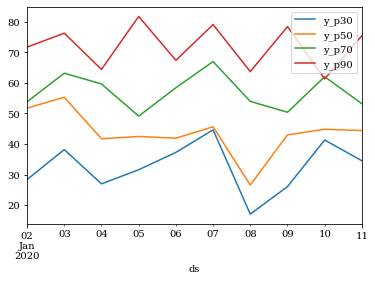

In [ ]:
forecast.query('unique_id == "uid_1"').set_index('ds').plot()

# Attention Res


## Block

In [5]:
import torch
import torch.nn as nn


# Cell
__all__ = ['LSTMCell', 'ResLSTMCell', 'ResLSTMLayer', 'AttentiveLSTMLayer', 'DRNN']

# Cell
import torch
import torch.nn as nn

# Cell
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)
        gates = (torch.matmul(inputs, self.weight_ih.t()) + self.bias_ih +
                         torch.matmul(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)

# Cell
class ResLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.register_buffer('input_size', torch.Tensor([input_size]))
        self.register_buffer('hidden_size', torch.Tensor([hidden_size]))
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)

        ifo_gates = (torch.matmul(inputs, self.weight_ii.t()) + self.bias_ii +
                                  torch.matmul(hx, self.weight_ih.t()) + self.bias_ih +
                                  torch.matmul(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)

        cellgate = torch.matmul(hx, self.weight_hh.t()) + self.bias_hh

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
            hy = outgate * (ry + inputs)
        else:
            hy = outgate * (ry + torch.matmul(inputs, self.weight_ir.t()))
        return hy, (hy, cy)

# Cell
class ResLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        print(len(inputs))
        outputs = []
        for i in range(len(inputs)):
                out, hidden = self.cell(inputs[i], hidden)
                outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

class SelfAttnResLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(SelfAttnResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        print(len(inputs))
        outputs = []
        for i in range(len(inputs)):
                out, hidden = self.cell(inputs[i], hidden)
                outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden


# Cell
class AttentiveLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super(AttentiveLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        attention_hsize = hidden_size
        self.attention_hsize = attention_hsize

        self.cell = LSTMCell(input_size, hidden_size)
        self.attn_layer = nn.Sequential(nn.Linear(2 * hidden_size + input_size, attention_hsize),
                                        nn.Tanh(),
                                        nn.Linear(attention_hsize, 1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = dropout

    def forward(self, inputs, hidden):
        #inputs = inputs.unbind(0)
        outputs = []
        #print(len(inputs)) #12

        for t in range(len(inputs)):

            # attention on windows
            hx, cx = (tensor.squeeze(0) for tensor in hidden)
            hx_rep = hx.repeat(len(inputs), 1, 1) #torch.Size([12, 6, 20])
            cx_rep = cx.repeat(len(inputs), 1, 1)
            #print(inputs[0].shape)
            # input = (6, 10)
            x = torch.cat((inputs, hx_rep, cx_rep), dim=-1)
            l = self.attn_layer(x)
            beta = self.softmax(l)
            context = torch.bmm(beta.permute(1, 2, 0),
                                inputs.permute(1, 0, 2)).squeeze(1)
            out, hidden = self.cell(context, hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

class AttentiveResLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super(AttentiveResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        attention_hsize = hidden_size
        self.attention_hsize = attention_hsize

        self.cell = ResLSTMCell(input_size, hidden_size)
        self.attn_layer = nn.Sequential(nn.Linear(2 * hidden_size + input_size, attention_hsize),
                                        nn.Tanh(),
                                        nn.Linear(attention_hsize, 1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = dropout

    def forward(self, inputs, hidden):
        #inputs = inputs.unbind(0)
        outputs = []

        for t in range(len(inputs)):
            # attention on windows
            hx, cx = (tensor.squeeze(0) for tensor in hidden)
            hx_rep = hx.repeat(len(inputs), 1, 1)
            cx_rep = cx.repeat(len(inputs), 1, 1)
            x = torch.cat((inputs, hx_rep, cx_rep), dim=-1)
            l = self.attn_layer(x)
            beta = self.softmax(l)
            context = torch.bmm(beta.permute(1, 2, 0),
                                inputs.permute(1, 0, 2)).squeeze(1)
            out, hidden = self.cell(context, hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden


class DRNN(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dilations, dropout=0, cell_type='GRU', batch_first=False):
        super(DRNN, self).__init__()

        self.dilations = dilations
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        elif self.cell_type == "ResLSTM":
            cell = ResLSTMLayer
        elif self.cell_type == "AttentiveLSTM":
            cell = AttentiveLSTMLayer
        elif self.cell_type == 'AttentiveResLSTM':
            cell = AttentiveResLSTMLayer
        elif self.cell_type == 'SelfAttnResLSTMLayer':
            cell = SelfAttnResLSTMLayer

        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hidden, dropout=dropout)
            else:
                c = cell(n_hidden, n_hidden, dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])

            outputs.append(inputs[-dilation:])

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, dilated_steps = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size,
                                                       hidden=hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)

        return outputs, hidden

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            hidden = torch.zeros(batch_size * rate, hidden_size,
                                 dtype=dilated_inputs.dtype,
                                 device=dilated_inputs.device)
            hidden = hidden.unsqueeze(0)

            if self.cell_type in ['LSTM', 'ResLSTM', 'AttentiveLSTM','AttentiveResLSTM']:
            #if self.cell_type in ['LSTM', 'ResLSTM', 'AttentiveLSTM']:
                hidden = (hidden, hidden)

            elif self.cell_type == 'SelfAttnResLSTMLayer':
                hidden = (hidden, hidden)

        dilated_outputs, hidden = cell(dilated_inputs, hidden) # compatibility hack

        return dilated_outputs, hidden

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]

        interleaved = torch.stack((blocks)).transpose(1, 0).contiguous()
        interleaved = interleaved.view(dilated_outputs.size(0) * rate,
                                       batchsize,
                                       dilated_outputs.size(2))
        return interleaved

    def _pad_inputs(self, inputs, n_steps, rate):
        iseven = (n_steps % rate) == 0

        if not iseven:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0),
                                 inputs.size(1),
                                 inputs.size(2),
                                 dtype=inputs.dtype,
                                 device=inputs.device)
            inputs = torch.cat((inputs, zeros_))
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs


if __name__ == '__main__':
    n_time = 24
    batch_size = 3
    n_feats = 10
    n_output_feats = 20
    num_layers = 4
    dilations = [2, 4, 5, 9]

    #test = torch.rand(24, 4, 200)
    #print(len(test.chunk(4,1))) #4这个位置必须一致

    #for cell_type in ['GRU', 'RNN', 'LSTM', 'ResLSTM','AttentiveLSTM','AttentiveResLSTM']:
    #for
    cell_type = ['GRU', 'RNN', 'LSTM', 'ResLSTM', 'AttentiveLSTM','AttentiveResLSTM']
    model = DRNN(n_input=n_feats, n_hidden=n_output_feats, n_layers=num_layers,
                 dilations=dilations, cell_type=cell_type[4])
    x = torch.rand(n_time, batch_size, n_feats)
    output, hidden = model(x)
        #test_eq(output.shape, (n_time, batch_size, n_output_feats))


In [6]:

__all__ = ['ESRNN']

# Cell
import numpy as np
import torch as t
import torch.nn as nn


# Cell
#TODO: rnn con canales
#TODO: notacion de todo, windows_y_insample
class _ES(nn.Module):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ES, self).__init__()

        self.n_series = n_series
        self.input_size = input_size
        self.output_size = output_size
        self.output_size_m = output_size_m
        self.n_t = n_t
        self.n_s = n_s
        self.seasonality = seasonality
        assert len(self.seasonality) in [0, 1, 2]

        self.noise_std = noise_std

    def gaussian_noise(self, Y: t.Tensor, std: float=0.2):
        size = Y.size()
        noise = t.autograd.Variable(Y.data.new(size).normal_(0, std))
        return Y + noise

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        pass

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor, start: int, end: int):
        pass

    def predict(self, trend: t.Tensor, levels: t.Tensor, seasonalities: t.Tensor):
        pass

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # parse attributes
        input_size = self.input_size
        output_size = self.output_size
        n_t = self.n_t
        n_s = self.n_s
        context_size = input_size + (input_size+output_size)*n_t + n_s
        noise_std = self.noise_std
        seasonality = self.seasonality
        batch_size = len(idxs)

        n_series, n_time = Y.shape

        # Explicacion: windows_end es el idx delultimo inicio de windows. Como se necesitan windows completas con input
        # + output, se pierden (input_size+output_size-1) windows del len total de la serie.
        windows_end = n_time - input_size - output_size + 1
        #windows_range = range(0, windows_end, step_size)
        windows_range = range(0, windows_end)
        n_windows = len(windows_range)

        assert n_windows>0

        # Initialize windows, levels and seasonalities
        levels, seasonalities = self.compute_levels_seasons(Y=Y, idxs=idxs)
        windows_y_insample = t.zeros((n_windows, batch_size, context_size),
                                     device=Y.device)
        windows_y_outsample = t.zeros((n_windows, batch_size, output_size),
                                      device=Y.device)

        for i, window in enumerate(windows_range):
            # Windows yhat
            y_insample_start = window
            y_insample_end   = input_size + window

            # Y_hat deseasonalization and normalization
            window_y_insample = self.normalize(Y=Y[:, y_insample_start:y_insample_end],
                                               level=levels[:, [y_insample_end-1]],
                                               seasonalities=seasonalities,
                                               start=y_insample_start, end=y_insample_end) #TODO: improve this inputs

            if self.training:
                window_y_insample = self.gaussian_noise(window_y_insample, std=noise_std)

            if n_t > 0:
                window_x_t = X[:, :, y_insample_start:(y_insample_end+output_size)]
                window_x_t = window_x_t.reshape(batch_size, -1)
                window_y_insample = t.cat((window_y_insample, window_x_t), 1)

            # Concatenate S static variables matrix
            if n_s > 0:
                window_y_insample = t.cat((window_y_insample, S), 1)

            windows_y_insample[i, :, :] += window_y_insample

            # Windows_y_outsample
            y_outsample_start = y_insample_end
            y_outsample_end = y_outsample_start + output_size
            window_y_outsample = Y[:, y_outsample_start:y_outsample_end]
            # If training, normalize outsample for loss on normalized data
            if self.training:
                # Y deseasonalization and normalization
                window_y_outsample = self.normalize(Y=window_y_outsample,
                                                    level=levels[:, [y_outsample_start]],
                                                    seasonalities=seasonalities,
                                                    start=y_outsample_start, end=y_outsample_end) #TODO: improve this inputs
            windows_y_outsample[i, :, :] += window_y_outsample


        # Wrangles the sample_mask with same indexes as windows_y_outsample
        n_windows, n_batch, n_output = windows_y_outsample.shape
        sample_mask = sample_mask.unfold(dimension=-1, size=self.output_size, step=1)
        sample_mask = sample_mask[:, -n_windows:, :]
        sample_mask = sample_mask.permute(1,0,2)

        return windows_y_insample, windows_y_outsample, levels, seasonalities, sample_mask

# Cell
class _ESI(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ESI, self).__init__(n_series, input_size, output_size,
                                   output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        self.W = t.nn.Parameter(t.randn(1))
        self.W.requires_grad = False

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        levels = t.ones(Y.shape, device=Y.device)
        seasonalities = None
        return levels, None

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor,
                  start: int, end: int):
        return Y

    def predict(self,
                trends: t.Tensor,
                levels: t.Tensor,
                seasonalities: t.Tensor):
        return trends

# Cell
class _MedianResidual(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_MedianResidual, self).__init__(n_series, input_size, output_size, output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        self.W = t.nn.Parameter(t.randn(1))
        self.W.requires_grad = False

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        """
        Computes levels and seasons
        """
        y_transformed, _ = Y.median(1)
        y_transformed = y_transformed.reshape(-1, 1)
        levels = y_transformed.repeat(1, Y.shape[1])
        seasonalities = None

        return levels, None

    def normalize(self, Y: t.Tensor, level: t.Tensor,
                  seasonalities: t.Tensor,
                  start: int, end: int):

        return Y - level

    def predict(self,
                trends: t.Tensor,
                levels: t.Tensor,
                seasonalities: t.Tensor):
        levels = levels[:, (self.input_size-1):-self.output_size]
        levels = levels.unsqueeze(2)

        return trends + levels

# Cell
class _ESM(_ES):
    def __init__(self, n_series: int, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, seasonality: list, noise_std: float):
        super(_ESM, self).__init__(n_series, input_size, output_size,
                                   output_size_m,
                                   n_t, n_s, seasonality, noise_std)
        # Level and Seasonality Smoothing parameters
        # 1 level, S seasonalities, S init_seas
        embeds_size = 1 + len(self.seasonality) + sum(self.seasonality)
        init_embeds = t.ones((self.n_series, embeds_size)) * 0.5
        self.embeds = nn.Embedding(self.n_series, embeds_size)
        self.embeds.weight.data.copy_(init_embeds)
        self.seasonality = t.LongTensor(self.seasonality)

    def compute_levels_seasons(self, Y: t.Tensor, idxs: t.Tensor):
        """
        Computes levels and seasons
        """
        # Lookup parameters per serie
        #seasonality = self.seasonality
        embeds = self.embeds(idxs)
        lev_sms = t.sigmoid(embeds[:, 0])

        # Initialize seasonalities
        seas_prod = t.ones(len(Y[:,0]), device=Y.device)
        seasonalities1 = []
        seasonalities2 = []
        seas_sms1 = t.ones(1, device=Y.device)
        seas_sms2 = t.ones(1, device=Y.device)

        if len(self.seasonality)>0:
            seas_sms1 = t.sigmoid(embeds[:, 1])
            init_seas1 = t.exp(embeds[:, 2:(2+self.seasonality[0])]).unbind(1)
            assert len(init_seas1) == self.seasonality[0]

            for i in range(len(init_seas1)):
                seasonalities1 += [init_seas1[i]]
            seasonalities1 += [init_seas1[0]]
            seas_prod = seas_prod * init_seas1[0]

        if len(self.seasonality)==2:
            seas_sms2 = t.sigmoid(embeds[:, 2+self.seasonality[0]])
            init_seas2 = t.exp(embeds[:, 3+self.seasonality[0]:]).unbind(1)
            assert len(init_seas2) == self.seasonality[1]

            for i in range(len(init_seas2)):
                seasonalities2 += [init_seas2[i]]
            seasonalities2 += [init_seas2[0]]
            seas_prod = seas_prod * init_seas2[0]

        # Initialize levels
        levels = []
        levels += [Y[:,0]/seas_prod]

        # Recursive seasonalities and levels
        ys = Y.unbind(1)
        n_time = len(ys)
        for t_idx in range(1, n_time):
            seas_prod_t = t.ones(len(Y[:,t_idx]), device=Y.device)
            if len(self.seasonality)>0:
                seas_prod_t = seas_prod_t * seasonalities1[t_idx]
            if len(self.seasonality)==2:
                seas_prod_t = seas_prod_t * seasonalities2[t_idx]

            newlev = lev_sms * (ys[t_idx] / seas_prod_t) + (1-lev_sms) * levels[t_idx-1]
            levels += [newlev]

            if len(self.seasonality)==1:
                newseason1 = seas_sms1 * (ys[t_idx] / newlev) + (1-seas_sms1) * seasonalities1[t_idx]
                seasonalities1 += [newseason1]

            if len(self.seasonality)==2:
                newseason1 = seas_sms1 * (ys[t_idx] / (newlev * seasonalities2[t_idx])) + \
                                         (1-seas_sms1) * seasonalities1[t_idx]
                seasonalities1 += [newseason1]
                newseason2 = seas_sms2 * (ys[t_idx] / (newlev * seasonalities1[t_idx])) + \
                                         (1-seas_sms2) * seasonalities2[t_idx]
                seasonalities2 += [newseason2]

        levels = t.stack(levels).transpose(1,0)

        seasonalities = []

        if len(self.seasonality)>0:
            seasonalities += [t.stack(seasonalities1).transpose(1,0)]

        if len(self.seasonality)==2:
            seasonalities += [t.stack(seasonalities2).transpose(1,0)]

        return levels, seasonalities

    def normalize(self, Y: t.Tensor, level: t.Tensor, seasonalities: t.Tensor,
                  start: int, end: int):
        # Deseasonalization and normalization
        y_n = Y / level
        for s in range(len(self.seasonality)):
            y_n /= seasonalities[s][:, start:end]
        y_n = t.log(y_n)
        return y_n

    def predict(self, trends: t.Tensor, levels: t.Tensor, seasonalities: t.Tensor):

        # First trend uses last value of first y_insample of length self.input_size.
        # Last self.output_size levels are not used (leakeage!!!)
        levels = levels[:, (self.input_size-1):-self.output_size]
        levels = levels.unsqueeze(2)

        # Seasonalities are unfolded, because each element of trends must be multiplied
        # by the corresponding seasonality.
        for i in range(len(seasonalities)):
            seasonalities[i] = seasonalities[i][:, self.seasonality[i]:]
            seasonalities[i] = seasonalities[i].unfold(dimension=-1,
                                                       size=self.input_size + self.output_size,
                                                       step=1)
            seasonalities[i] = seasonalities[i][:,:,:self.input_size] #avoid leakage

            # Fill seasonalities with NaiveSeasonal, to avoid leakage.
            if self.output_size > seasonalities[i].shape[2]:
                repetitions = int(np.ceil(self.output_size / seasonalities[i].shape[2]))
                seasonalities[i] = seasonalities[i].repeat((1, 1, repetitions))
            seasonalities[i] = seasonalities[i][:, :, :self.output_size]

        # Denormalize
        trends = t.exp(trends)
        # Deseasonalization and normalization (inverse)
        y_hat = trends * levels
        for s in range(len(self.seasonality)):
            seas = seasonalities[s]
            y_hat *= t.vstack([seas.T for _ in range(self.output_size_m)]).T

        return y_hat

# Cell
class _RNN(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 output_size_m: int,
                 n_t: int, n_s: int, cell_type: str, dilations: list, state_hsize: int, add_nl_layer: bool):
        super(_RNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_size_m = output_size_m
        self.n_t = n_t
        self.n_s = n_s

        self.cell_type = cell_type
        self.dilations = dilations
        self.state_hsize = state_hsize
        self.add_nl_layer = add_nl_layer
        self.layers = len(dilations)

        layers = []
        for grp_num in range(len(self.dilations)):
            if grp_num == 0:
                input_size = self.input_size + (self.input_size + self.output_size)*self.n_t + self.n_s
            else:
                input_size = self.state_hsize
            layer = DRNN(input_size,
                         self.state_hsize,
                         n_layers=len(self.dilations[grp_num]),
                         dilations=self.dilations[grp_num],
                         cell_type=self.cell_type)
            layers.append(layer)

        self.rnn_stack = nn.Sequential(*layers)

        if self.add_nl_layer:
            self.MLPW  = nn.Linear(self.state_hsize, self.state_hsize)

        self.adapterW  = nn.Linear(self.state_hsize, self.output_size * self.output_size_m)

    def forward(self, input_data: t.Tensor):
        for layer_num in range(len(self.rnn_stack)):
            residual = input_data
            output, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                output += residual
            input_data = output

        if self.add_nl_layer:
            input_data = self.MLPW(input_data)
            input_data = t.tanh(input_data)

        input_data = self.adapterW(input_data)

        return input_data

# Cell
class _ESRNN(nn.Module):
    def __init__(self, n_series, input_size, output_size,
                 output_size_m, n_t, n_s,
                 es_component, seasonality, noise_std, cell_type,
                 dilations, state_hsize, add_nl_layer):
        super(_ESRNN, self).__init__()
        allowed_componets = ['multiplicative', 'identity', 'median_residual']
        assert es_component in allowed_componets, f'es_component {es_component} not valid.'
        self.es_component = es_component

        if es_component == 'multiplicative':
            self.es = _ESM(n_series=n_series, input_size=input_size, output_size=output_size,
                           output_size_m=output_size_m, n_t=n_t, n_s=n_s,
                           seasonality=seasonality, noise_std=noise_std)
        elif es_component == 'identity':
            self.es = _ESI(n_series=n_series, input_size=input_size, output_size=output_size,
                           output_size_m=output_size_m, n_t=n_t, n_s=n_s,
                           seasonality=seasonality, noise_std=noise_std)
        elif es_component == 'median_residual':
            self.es = _MedianResidual(n_series=n_series, input_size=input_size, output_size=output_size,
                                      output_size_m=output_size_m, n_t=n_t, n_s=n_s,
                                      seasonality=seasonality, noise_std=noise_std)

        self.rnn = _RNN(input_size=input_size, output_size=output_size,
                        output_size_m=output_size_m,
                        n_t=n_t, n_s=n_s,
                        cell_type=cell_type, dilations=dilations,
                        state_hsize=state_hsize,
                        add_nl_layer=add_nl_layer)

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # Multiplicative model protection
        if self.es_component == 'multiplicative' and t.min(Y) == 0:
            raise Exception(
                'Check your Y data, multiplicative model only deals with Y>0. \n'
                f'Series: {idxs} \n'
                f'Min Y: {t.min(Y)}'
            )

        # ES Forward
        y_in, y_out, levels, seasonalities, sample_mask = self.es(S=S,Y=Y,X=X,idxs=idxs,
                                                                  sample_mask=sample_mask)

        # RNN Forward
        y_hat = self.rnn(y_in)

        if self.rnn.output_size_m > 1:
            n_w, n_ts, _ = y_in.shape
            y_hat = y_hat.view(n_w, n_ts, -1, self.rnn.output_size_m)

        return y_out, y_hat, levels, sample_mask

    def predict(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                idxs: t.Tensor, sample_mask: t.Tensor):
        # ES Forward
        y_in, y_out, levels, seasonalities, sample_mask = self.es(S=S,Y=Y,X=X,idxs=idxs,
                                                                  sample_mask=sample_mask)
        # RNN Forward
        trends = self.rnn(y_in)

        # (n_windows, n_batch, n_input) -> (n_batch, n_windows, n_input)
        y_out = y_out.permute(1,0,2)
        trends = trends.permute(1,0,2)
        sample_mask = sample_mask.permute(1,0,2)

        y_hat = self.es.predict(trends, levels, seasonalities)

        if self.rnn.output_size_m > 1:
            n_ts, n_w, _ = y_out.shape
            y_hat = y_hat.view(n_ts, n_w, -1, self.rnn.output_size_m)

        return y_out, y_hat, sample_mask

In [10]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

# Cell
from typing import Union, List

import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
from fastcore.foundation import patch
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.losses.utils import LossFunction


class ESRNN(pl.LightningModule):
    def __init__(self, n_series: int,
                 input_size: int, output_size: int,
                 n_x: int = 0, n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'multiplicative',
                 cell_type: str = 'LSTM', state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False, seasonality: List[int] = [],
                 learning_rate: float = 1e-3, lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9, per_series_lr_multip: float = 1.,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0., noise_std: float = 1e-3,
                 level_variability_penalty: float = 20.,
                 testing_percentile: Union[int, List] = 50,
                 training_percentile: Union[int, List] = 50,
                 loss: str = 'SMYL', val_loss: str = 'MAE',
                 frequency: str = 'D'):
        super(ESRNN, self).__init__()
        """ Exponential Smoothing Recurrent Neural Network
        Pytorch Implementation of the M4 time series forecasting competition winner.
        Proposed by Smyl. The model uses a hybrid approach of Machine Learning and
        statistical methods by combining recurrent neural networks to model a common
        trend with shared parameters across series, and multiplicative Holt-Winter
        exponential smoothing.
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        seasonality: int list
            list of seasonalities of the time series
            Hourly [24, 168], Daily [7], Weekly [52], Monthly [12],
            Quarterly [4], Yearly [].
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentile: int
            This value is only for diagnostic evaluation.
            In case of percentile predictions this parameter controls
            for the value predicted, when forecasting point value,
            the forecast is the median, so percentile=50.
        training_percentile: float
            To reduce the model's tendency to over estimate, the
            training_percentile can be set to fit a smaller value
            through the Pinball Loss.
        loss: str
            Loss used to train.
        val_loss: str
            Loss used to validate.
        frequency: str
            Time series frequency.
        Notes
        -----
        **References:**
        `M4 Competition Conclusions
        <https://rpubs.com/fotpetr/m4competition>`__
        `Original Dynet Implementation of ESRNN
        <https://github.com/M4Competition/M4-methods/tree/master/118%20-%20slaweks17>`__
        """

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_series = n_series
        self.n_x = n_x
        self.n_s = n_s
        self.sample_freq = sample_freq
        self.input_size = input_size
        self.output_size = output_size
        self.es_component = es_component
        self.cell_type = cell_type
        self.state_hsize = state_hsize
        self.dilations = dilations
        self.add_nl_layer = add_nl_layer
        self.seasonality = seasonality

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_scheduler_step_size = lr_scheduler_step_size
        self.lr_decay = lr_decay
        self.per_series_lr_multip = per_series_lr_multip
        self.gradient_eps = gradient_eps
        self.gradient_clipping_threshold = gradient_clipping_threshold
        self.rnn_weight_decay = rnn_weight_decay
        self.noise_std = noise_std
        self.level_variability_penalty = level_variability_penalty
        self.testing_percentile = testing_percentile
        self.training_percentile = training_percentile
        self.loss = loss
        self.val_loss = val_loss
        self.loss_fn = LossFunction(loss,
                                    percentile=self.training_percentile,
                                    level_variability_penalty=self.level_variability_penalty)
        self.val_loss_fn = LossFunction(val_loss,
                                        percentile=self.testing_percentile,
                                        level_variability_penalty=self.level_variability_penalty)

        self.frequency = frequency
        # MQESRNN
        self.mq = isinstance(self.training_percentile, list)
        self.output_size_m = len(self.training_percentile) if self.mq else 1

        #Defining model
        self.model = _ESRNN(n_series=self.n_series,
                            input_size=self.input_size,
                            output_size=self.output_size,
                            output_size_m=self.output_size_m,
                            n_t=self.n_x, n_s=self.n_s,
                            es_component=self.es_component,
                            seasonality=self.seasonality,
                            noise_std=self.noise_std,
                            cell_type=self.cell_type,
                            dilations=self.dilations,
                            state_hsize=self.state_hsize,
                            add_nl_layer=self.add_nl_layer)

        self.automatic_optimization = False

    def parse_batch(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        #idxs = batch['ts_idxs']
        idxs = batch['idxs']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        av_condition = t.nonzero(t.min(available_mask, axis=0).values)
        min_time_stamp = int(av_condition.min())
        sample_condition = t.nonzero(t.min(sample_mask, axis=0).values)

        if sample_condition.nelement() == 0:
            max_time_stamp = int(av_condition.max())
        else:
            max_time_stamp = int(sample_condition.max())
        available_ts = max_time_stamp - min_time_stamp + 1 # +1, inclusive counting
        if available_ts < self.input_size + self.output_size:
            raise Exception(
                'Time series too short for given input and output size. \n'
                f'Available timestamps: {available_ts}'
            )

        Y = Y[:, min_time_stamp:max_time_stamp + 1] #+1 because is not inclusive
        X = X[:, :, min_time_stamp:max_time_stamp + 1]
        sample_mask = sample_mask[:, min_time_stamp:max_time_stamp + 1]
        available_mask = available_mask[:, min_time_stamp:max_time_stamp + 1]

        return S, Y, X, idxs, sample_mask, available_mask

    def training_step(self, batch, batch_idx):
        es_opt, rnn_opt = self.optimizers()

        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        target, forecast, levels, sample_mask = self.model(S=S, Y=Y, X=X, idxs=idxs,
                                                           sample_mask=sample_mask)
        loss = self.loss_fn(y=target,
                            y_hat=forecast,
                            y_insample=Y,
                            levels=levels,
                            mask=sample_mask)

        es_opt.zero_grad()
        rnn_opt.zero_grad()
        self.manual_backward(loss)
        clip_grad_norm_(parameters=self.model.rnn.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        clip_grad_norm_(parameters=self.model.es.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        es_opt.step()
        rnn_opt.step()

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        for lr_scheduler in self.lr_schedulers():
            lr_scheduler.step()

    def validation_step(self, batch, idx):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        y_true, y_hat, sample_mask = self.model.predict(S=S, Y=Y, X=X, idxs=idxs,
                                                        sample_mask=sample_mask)

        y_true = y_true[:, ::self.sample_freq]
        y_hat = y_hat[:, ::self.sample_freq]
        sample_mask = sample_mask[:, ::self.sample_freq]

        loss = self.val_loss_fn(y=y_true,
                                y_hat=y_hat,
                                y_insample=Y)
        self.log('val_loss', loss, prog_bar=True)

        return loss

    def forward(self, batch):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        y_true, y_hat, sample_mask = self.model.predict(S=S, Y=Y, X=X, idxs=idxs,
                                                        sample_mask=sample_mask)

        y_true = y_true[:, ::self.sample_freq]
        y_hat = y_hat[:, ::self.sample_freq]
        sample_mask = sample_mask[:, ::self.sample_freq]

        return y_true, y_hat, sample_mask

    def configure_optimizers(self):
        es_optimizer = Adam(params=self.model.es.parameters(),
                            lr=self.learning_rate * self.per_series_lr_multip,
                            eps=self.gradient_eps)
        rnn_optimizer = Adam(params=self.model.rnn.parameters(),
                             lr=self.learning_rate,
                             eps=self.gradient_eps,
                             weight_decay=self.rnn_weight_decay)

        lr_es = StepLR(optimizer=es_optimizer,
                       step_size=self.lr_scheduler_step_size,
                       gamma=self.lr_decay)
        lr_rnn = StepLR(optimizer=rnn_optimizer,
                        step_size=self.lr_scheduler_step_size,
                        gamma=self.lr_decay)

        return [es_optimizer, rnn_optimizer], [lr_es, lr_rnn]

# Cell
@patch
def forecast(self: ESRNN, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None,
             batch_size: int =1, trainer: pl.Trainer =None) -> pd.DataFrame:
    """
    Method for forecasting self.output_size periods after last timestamp of Y_df.
    Parameters
    ----------
    Y_df: pd.DataFrame
        Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
    X_df: pd.DataFrame
        Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
        Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
    S_df: pd.DataFrame
        Dataframe with static data, needs 'unique_id' column.
    bath_size: int
        Batch size for forecasting.
    trainer: pl.Trainer
        Trainer object for model training and evaluation.
    Returns
    ----------
    forecast_df: pd.DataFrame
        Dataframe with forecasts.
    """

    # Add forecast dates to Y_df
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    if X_df is not None:
        X_df['ds'] = pd.to_datetime(X_df['ds'])
    forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.output_size+1, freq=self.frequency)[1:]
    index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
    forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()

    Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)

    # Dataset, loader and trainer
    dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df,
                                S_df=S_df,
                                ds_in_test=self.output_size,
                                is_test=True,
                                input_size=self.input_size,
                                output_size=self.output_size,
                                verbose=True)

    loader = TimeSeriesLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=False)

    if trainer is None:
        gpus = -1 if t.cuda.is_available() else 0
        trainer = pl.Trainer(progress_bar_refresh_rate=1,
                             gpus=gpus,
                             logger=False)

    # Forecast
    outputs = trainer.predict(self, loader)

    # Process forecast and include in forecast_df
    _, forecast, _ = zip(*outputs)
    forecast = t.cat([forecast_[:, -1] for forecast_ in forecast]).cpu().numpy()
    if self.mq:
        for iq, q in enumerate(self.training_percentile):
            forecast_df[f'y_p{q}'] = forecast[:, :, iq].flatten()
        forecast_df = forecast_df.drop(columns='y')
    else:
        forecast_df['y'] = forecast.flatten()

    return forecast_df

In [ ]:
# Cell
from typing import Union, List

import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
from fastcore.foundation import patch
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.losses.utils import LossFunction

In [18]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 n_x: int = 0,
                 n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'median_residual',
                 cell_type: str = 'LSTM',
                 state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False,
                 learning_rate: float = 1e-3,
                 lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0.,
                 noise_std: float = 1e-3,
                 testing_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 training_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 loss: str = 'MQ',
                 val_loss: str = 'MQ',
                 frequency: str = 'D'):
        """ Multi-Quantile Exponential Smoothing Recurrent Neural Network
    
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentiles: List[float]
            This values are only for diagnostic evaluation.
        training_percentiles: List[float]
            Percentiles to train and forecast.
        loss: str
            Loss used to train.
            Available: 'MQ', 'wMQ'.
        val_loss: str
            Loss used to validate.
            Available: 'MQ', 'wMQ'.
        frequency: str
            Time series frequency.
        
        Notes
        -----
        **References:**
        `Application
        <https://arxiv.org/abs/2112.05673`__
        """
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(n_series=n_series,
                                      n_s=n_s,
                                      n_x=n_x,
                                      sample_freq=sample_freq,
                                      input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss,
                                      frequency=frequency)

In [11]:

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

In [12]:
n_ds = 100 
n_ts = 1_000

output_size = 10

uids = [f'uid_{i + 1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

Y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [13]:
np.random.seed(10)
Y_df['y'] = Y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [14]:

Y_df = Y_df.sort_values(['unique_id', 'ds'])

In [15]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=3*output_size,
                                  is_test=False,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=False)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-12-03 2020-01-01
1           2019-09-24 2019-12-02
INFO:root:
Total data 			100000 time stamps 
Available percentage=100.0, 	100000 time stamps 
Insample  percentage=70.0, 	70000 time stamps 
Outsample percentage=30.0, 	30000 time stamps 



In [16]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=32,
                                shuffle=False)

In [19]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=7*2,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='AttentiveResLSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp344arau6
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp344arau6/_remote_module_non_sriptable.py


In [20]:
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=5, deterministic=True)
trainer.fit(model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=5)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
Missing logger folder: /content/lightning_logs

  | N

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
outputs = trainer.predict(model, valid_loader)

Predicting: 32it [00:00, ?it/s]

In [22]:
y_true, y_hat, mask = zip(*outputs)
y_true = t.cat(y_true).numpy()
y_hat = t.cat(y_hat).numpy()
mask = t.cat(mask).numpy()

In [23]:

y_true = y_true[-1000:, -1]
y_hat = y_hat[-1000:, -1]

calibration p30:  0.4979
calibration p50:  0.5137
calibration p70:  0.4901
calibration p90:  0.4978


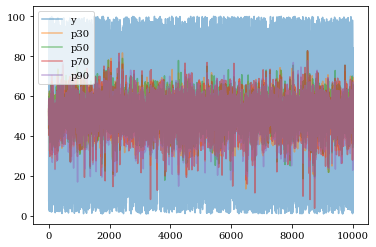

In [24]:
plt.plot(y_true.flatten(), alpha=0.5, label='y')
for idx, p in enumerate([30, 50, 70, 90]):
    y_p = y_hat[:, :, idx]
    plt.plot(y_p.flatten(), alpha=0.5, label=f'p{p}')
    print(f'calibration p{p}: ', (y_true.flatten() <= y_p.flatten()).mean())
plt.legend()

# multiquantile

In [25]:

import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t
import matplotlib.pyplot as plt

In [26]:
Y_df, _, S_df = nf.data.datasets.m5.M5.load('data')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

100%|██████████| 50.2M/50.2M [00:01<00:00, 48.5MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded m5.zip, 50219189, bytes.
INFO:neuralforecast.data.datasets.utils:Decompressing zip file...
INFO:neuralforecast.data.datasets.utils:Successfully decompressed data/m5/datasets/m5.zip


,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0


In [27]:
Y_df = Y_df.merge(S_df, how='left', on=['unique_id'])

In [28]:
Y_df = Y_df[['item_id', 'ds', 'y']].groupby(['item_id', 'ds']).sum().reset_index()

In [29]:
Y_df = Y_df.rename(columns={'item_id': 'unique_id'})

In [30]:
Y_df = Y_df.groupby('unique_id').tail(100)

In [31]:
uids = Y_df['unique_id'].unique()[:100]
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

In [32]:
Y_df

,unique_id,ds,y
0,HOBBIES_1_001,2016-03-12,8.0
1,HOBBIES_1_001,2016-03-13,6.0
2,HOBBIES_1_001,2016-03-14,5.0
3,HOBBIES_1_001,2016-03-15,6.0
4,HOBBIES_1_001,2016-03-16,5.0
...,...,...,...
9995,HOBBIES_1_104,2016-06-15,2.0
9996,HOBBIES_1_104,2016-06-16,5.0
9997,HOBBIES_1_104,2016-06-17,2.0
9998,HOBBIES_1_104,2016-06-18,6.0


In [33]:
output_size = 7
Y_df_test = Y_df.groupby('unique_id').tail(output_size)
Y_df_train = Y_df.drop(Y_df_test.index)

In [34]:
input_size = 4 * output_size

In [35]:
input_size

28

In [36]:
train_mask_df, val_mask_df, _ = nf.experiments.utils.get_mask_dfs(
    Y_df=Y_df_train,
    ds_in_val=3 * output_size,
    ds_in_test=0
)

In [37]:
plot_df = Y_df_train.merge(
    train_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_train'}),
    how='left',
    on=['unique_id', 'ds']
).merge(
    val_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_val'}),
    how='left',
    on=['unique_id', 'ds']
)

In [38]:
plot_df['y_train'] = np.where(plot_df['sample_mask_train'] == 1, plot_df['y'], np.nan)
plot_df['y_val'] = np.where(plot_df['sample_mask_val'] == 1, plot_df['y'], np.nan)

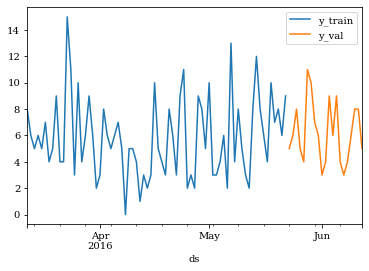

In [39]:
plot_df.query('unique_id == "HOBBIES_1_001"').set_index('ds')[['y_train', 'y_val']].plot()

In [44]:
train_dataset = nf.data.tsdataset.TimeSeriesDataset(
    Y_df=Y_df_train, 
    input_size=input_size,
    output_size=output_size,
    mask_df=train_mask_df,
    verbose=True
  
)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2016-05-23 2016-06-12
1           2016-03-12 2016-05-22
INFO:root:
Total data 			9300 time stamps 
Available percentage=100.0, 	9300 time stamps 
Insample  percentage=77.42, 	7200 time stamps 
Outsample percentage=22.58, 	2100 time stamps 



In [45]:
val_dataset = nf.data.tsdataset.TimeSeriesDataset(
    Y_df=Y_df_train, 
    input_size=input_size,
    output_size=output_size,
    mask_df=val_mask_df,
    verbose=True
)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2016-03-12 2016-05-22
1           2016-05-23 2016-06-12
INFO:root:
Total data 			9300 time stamps 
Available percentage=100.0, 	9300 time stamps 
Insample  percentage=22.58, 	2100 time stamps 
Outsample percentage=77.42, 	7200 time stamps 



In [42]:
train_loader = nf.data.tsloader.TimeSeriesLoader(
    train_dataset, batch_size=256, 
    shuffle=True
)

In [43]:
val_loader = nf.data.tsloader.TimeSeriesLoader(
    val_dataset, 
    batch_size=1
)

In [46]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=input_size,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[5, 20, 50, 80, 95],
                training_percentiles=[5, 20, 50, 80, 95],
                es_component='median_residual',
                cell_type='AttentiveResLSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

In [47]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss")

trainer = pl.Trainer(max_epochs=100,
                     gpus=-1 if t.cuda.is_available() else 0,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | _ESRNN | 532 K 
---------------------------------
532 K     Trainable params
1         Non-trainable params
532 K     Total params
2.129     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [48]:
Y_df_forecast = model.forecast(Y_df_train)
Y_df_forecast.head()

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2016-03-12 2016-06-12
1           2016-06-13 2016-06-19
INFO:root:
Total data 			10000 time stamps 
Available percentage=100.0, 	10000 time stamps 
Insample  percentage=7.0, 	700 time stamps 
Outsample percentage=93.0, 	9300 time stamps 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,y_p5,y_p20,y_p50,y_p80,y_p95
0,HOBBIES_1_001,2016-06-13,4.770733,2.342470,2.938547,4.912870,5.117584
1,HOBBIES_1_001,2016-06-14,2.632704,7.524996,5.959220,5.379098,4.019555
2,HOBBIES_1_001,2016-06-15,4.204811,4.882662,4.184138,5.252892,7.420852
3,HOBBIES_1_001,2016-06-16,4.133768,5.263874,6.138991,4.732797,3.695467
4,HOBBIES_1_001,2016-06-17,6.269267,4.757730,4.067233,4.176614,7.739632


In [49]:
Y_df_plot = Y_df_test.merge(Y_df_forecast, how='left', on=['unique_id', 'ds'])

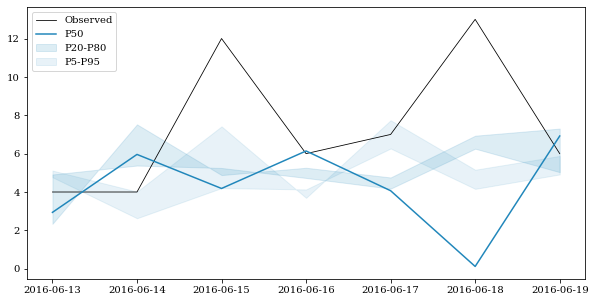

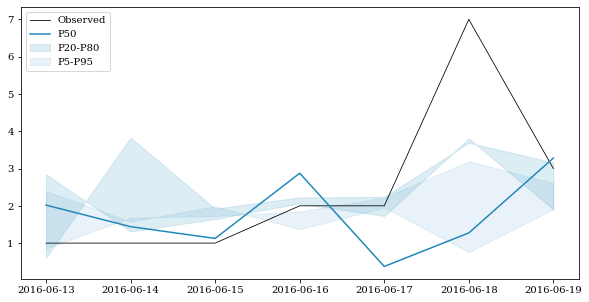

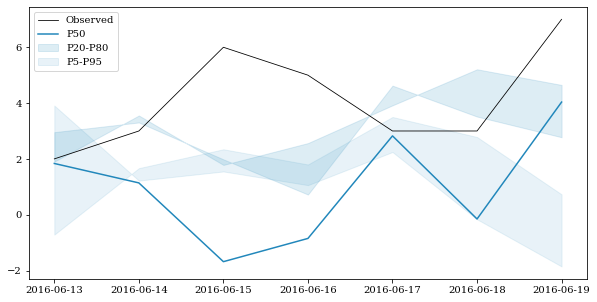

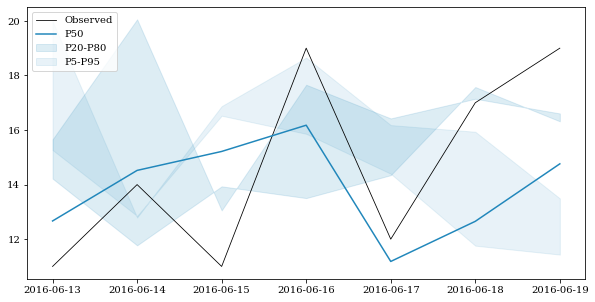

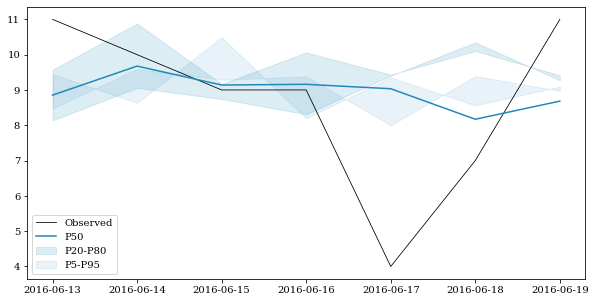

In [50]:
for uid in Y_df_plot['unique_id'].unique()[:5]:
    df_plot = Y_df_plot.query('unique_id == @uid')
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_plot['ds'], df_plot['y'], label='Observed', color='black', linewidth=0.8)
    ax.plot(df_plot['ds'], df_plot['y_p50'], label='P50', color='#2187bb')
    ax.fill_between(df_plot['ds'], df_plot['y_p20'], df_plot['y_p80'], color='#2187bb', alpha=.15, label='P20-P80')
    ax.fill_between(df_plot['ds'], df_plot['y_p5'], df_plot['y_p95'], color='#2187bb', alpha=.10, label='P5-P95')
    ax.legend()